In [1]:
from typing import List, Dict
from csv import DictReader

def open_data(filename: str) -> List[Dict[str, str]]:
    """
    Opens CSV file, returns entries
    """

    with open(filename, 'r') as csv_file:
        reader = DictReader(csv_file)
        rows = [r for r in reader]
    csv_file.close()
    return rows

def prune_data(rows: List[Dict[str, str]]) -> List[Dict[str, float]]:
    """
    Removes data samples with blank values in input/target data
    """

    _to_omit = ['Reaction time (s)']

    new_rows = []
    keys = list(rows[0].keys())
    for row in rows:
        new_row = {}
        _valid = True
        for k in keys:
            if k in _to_omit:
                continue
            try:
                new_row[k] = float(row[k])
            except ValueError:
                _valid = False
                break
        if _valid:
            new_rows.append(new_row)
    return new_rows

data_fb = open_data('_data/fluidized_bed.csv')
data_fb = prune_data(data_fb)
data_tr = open_data('_data/tubular_reactor.csv')
data_tr = prune_data(data_tr)
data_br = open_data('_data/batch_reactor.csv')
data_br = prune_data(data_br)

print(len(data_fb), len(data_tr), len(data_br))

38 23 18


In [2]:
from structs import ReactorDataset
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

def create_dataset(data: List[Dict[str, float]], target_headers: List[str]) -> 'structs.ReactorDataset':

    input_headers = list(data[0].keys())
    for head in target_headers:
        input_headers.remove(head)

    X = np.asarray(normalize(
        [[sample[inp] for inp in input_headers] for sample in data]
    ))
    y = np.asarray(
        [[0.01 * sample[tar] for tar in target_headers] for sample in data]
    )

    return ReactorDataset(X, y)

targets = ['Oil', 'Char', 'Gas']

fb_train, fb_test = train_test_split(data_fb, test_size=0.25, random_state=23)
tr_train, tr_test = train_test_split(data_tr, test_size=0.25, random_state=23)
br_train, br_test = train_test_split(data_br, test_size=0.25, random_state=23)

all_train = np.concatenate((fb_train, tr_train, br_train))
all_test = np.concatenate((fb_test, tr_test, br_test))

dataset_fb_train = create_dataset(fb_train, targets)
dataset_fb_test = create_dataset(fb_test, targets)
dataset_tr_train = create_dataset(tr_train, targets)
dataset_tr_test = create_dataset(tr_test, targets)
dataset_br_train = create_dataset(br_train, targets)
dataset_br_test = create_dataset(br_test, targets)

dataset_all_train = create_dataset(all_train, targets)
dataset_all_test = create_dataset(all_test, targets)

print('Training Sets:')
print(dataset_fb_train.X.shape, dataset_fb_train.y.shape)
print(dataset_tr_train.X.shape, dataset_tr_train.y.shape)
print(dataset_br_train.X.shape, dataset_br_train.y.shape)
print(dataset_all_train.X.shape, dataset_all_train.y.shape)
print('Testing Sets:')
print(dataset_fb_test.X.shape, dataset_fb_test.y.shape)
print(dataset_tr_test.X.shape, dataset_tr_test.y.shape)
print(dataset_br_test.X.shape, dataset_br_test.y.shape)
print(dataset_all_test.X.shape, dataset_all_test.y.shape)

Training Sets:
torch.Size([28, 9]) torch.Size([28, 3])
torch.Size([17, 9]) torch.Size([17, 3])
torch.Size([13, 9]) torch.Size([13, 3])
torch.Size([58, 9]) torch.Size([58, 3])
Testing Sets:
torch.Size([10, 9]) torch.Size([10, 3])
torch.Size([6, 9]) torch.Size([6, 3])
torch.Size([5, 9]) torch.Size([5, 3])
torch.Size([21, 9]) torch.Size([21, 3])


In [3]:
from structs import train_model, SoftmaxMLP

# Here we train 25 of each model, select the best (lowest final training loss)

_fb_model, _fb_loss, _fb_loss_final = [], [], []
_tr_model, _tr_loss, _tr_loss_final = [], [], []
_br_model, _br_loss, _br_loss_final = [], [], []
_all_model, _all_loss, _all_loss_final = [], [], []

for _ in range(25):

    model_fb = SoftmaxMLP(dataset_fb_train.X.shape[1], 64, 2, dataset_fb_train.y.shape[1])
    model_tr = SoftmaxMLP(dataset_tr_train.X.shape[1], 64, 2, dataset_tr_train.y.shape[1])
    model_br = SoftmaxMLP(dataset_br_train.X.shape[1], 64, 2, dataset_br_train.y.shape[1])
    model_all = SoftmaxMLP(dataset_all_train.X.shape[1], 64, 2, dataset_all_train.y.shape[1])

    model_fb_trained, train_losses_fb = train_model(
        model_fb, dataset_fb_train, epochs=500, batch_size=len(dataset_fb_train), lr=0.01
    )
    _fb_model.append(model_fb_trained)
    _fb_loss.append(train_losses_fb)
    _fb_loss_final.append(train_losses_fb[-1])

    model_tr_trained, train_losses_tr = train_model(
        model_tr, dataset_tr_train, epochs=500, batch_size=len(dataset_tr_train), lr=0.01
    )
    _tr_model.append(model_tr_trained)
    _tr_loss.append(train_losses_tr)
    _tr_loss_final.append(train_losses_tr[-1])

    model_br_trained, train_losses_br = train_model(
        model_br, dataset_br_train, epochs=500, batch_size=len(dataset_br_train), lr=0.01
    )
    _br_model.append(model_br_trained)
    _br_loss.append(train_losses_br)
    _br_loss_final.append(train_losses_br[-1])

    model_all_trained, train_losses_all = train_model(
        model_all, dataset_all_train, epochs=500, batch_size=len(dataset_all_train), lr=0.01
    )
    _all_model.append(model_all_trained)
    _all_loss.append(train_losses_all)
    _all_loss_final.append(train_losses_all[-1])

_best_fb = _fb_loss_final.index(min(_fb_loss_final))
_best_tr = _tr_loss_final.index(min(_tr_loss_final))
_best_br = _br_loss_final.index(min(_br_loss_final))
_best_all = _all_loss_final.index(min(_all_loss_final))

model_fb_trained = _fb_model[_best_fb]
train_losses_fb = _fb_loss[_best_fb]
model_tr_trained = _tr_model[_best_tr]
train_losses_tr = _tr_loss[_best_tr]
model_br_trained = _br_model[_best_br]
train_losses_br = _br_loss[_best_br]
model_all_trained = _all_model[_best_all]
train_losses_all = _all_loss[_best_all]

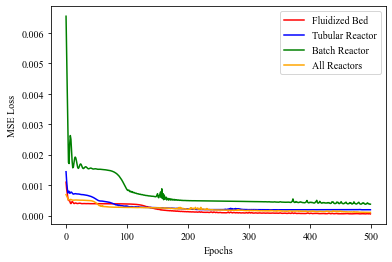

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
epochs = [i for i in range(len(train_losses_fb))]
plt.plot(epochs, train_losses_fb, color='red', label='Fluidized Bed')
plt.plot(epochs, train_losses_tr, color='blue', label='Tubular Reactor')
plt.plot(epochs, train_losses_br, color='green', label='Batch Reactor')
plt.plot(epochs, train_losses_all, color='orange', label='All Reactors')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(loc='upper right')
plt.show()

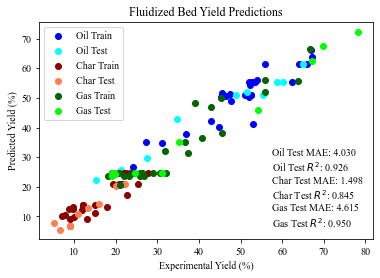

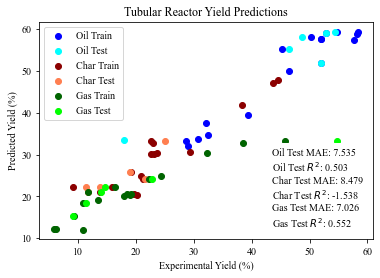

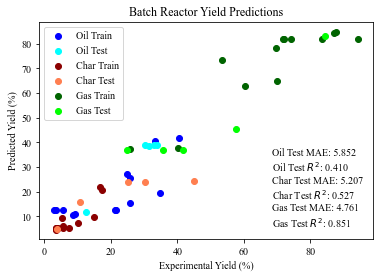

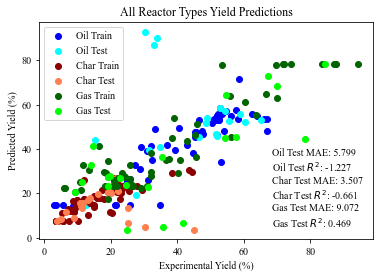

In [5]:
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib.offsetbox import AnchoredText

def plot_results(pred_train, targ_train, pred_test, targ_test, name):

    pred_oil_train = [100 * p[0] for p in pred_train]
    pred_char_train = [100 * p[1] for p in pred_train]
    pred_gas_train = [100 * p[2] for p in pred_train]

    targ_oil_train = [100 * t[0] for t in targ_train]
    targ_char_train = [100 * t[1] for t in targ_train]
    targ_gas_train = [100 * t[2] for t in targ_train]

    pred_oil_test = [100 * p[0] for p in pred_test]
    pred_char_test = [100 * p[1] for p in pred_test]
    pred_gas_test = [100 * p[2] for p in pred_test]

    targ_oil_test = [100 * t[0] for t in targ_test]
    targ_char_test = [100 * t[1] for t in targ_test]
    targ_gas_test = [100 * t[2] for t in targ_test]

    oil_test_mae = median_absolute_error(targ_oil_test, pred_oil_test)
    oil_test_r2 = r2_score(targ_oil_test, pred_oil_test)
    char_test_mae = median_absolute_error(targ_char_test, pred_char_test)
    char_test_r2 = r2_score(targ_char_test, pred_char_test)
    gas_test_mae = median_absolute_error(targ_gas_test, pred_gas_test)
    gas_test_r2 = r2_score(targ_gas_test, pred_gas_test)

    string = 'Oil Test MAE: {:.3f}\nOil Test $R^2$: {:.3f}\nChar Test MAE: {:.3f}\nChar Test $R^2$: {:.3f}\nGas Test MAE: {:.3f}\nGas Test $R^2$: {:.3f}'.format(
        oil_test_mae, oil_test_r2, char_test_mae, char_test_r2, gas_test_mae, gas_test_r2
    )
    text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)

    plt.clf()
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.title(f'{name} Yield Predictions')
    plt.xlabel('Experimental Yield (%)')
    plt.ylabel('Predicted Yield (%)')
    plt.scatter(targ_oil_train, pred_oil_train, color='blue', label='Oil Train')
    plt.scatter(targ_oil_test, pred_oil_test, color='cyan', label='Oil Test')
    plt.scatter(targ_char_train, pred_char_train, color='darkred', label='Char Train')
    plt.scatter(targ_char_test, pred_char_test, color='coral', label='Char Test')
    plt.scatter(targ_gas_train, pred_gas_train, color='darkgreen', label='Gas Train')
    plt.scatter(targ_gas_test, pred_gas_test, color='lime', label='Gas Test')
    plt.legend(loc='upper left')
    plt.setp(text_box.patch, facecolor='white', edgecolor='w')
    plt.gca().add_artist(text_box)
    plt.show()

pred_fb_train = model_fb_trained(dataset_fb_train.X).detach().numpy()
pred_tr_train = model_tr_trained(dataset_tr_train.X).detach().numpy()
pred_br_train = model_br_trained(dataset_br_train.X).detach().numpy()
pred_all_train = model_all_trained(dataset_all_train.X).detach().numpy()

targ_fb_train = dataset_fb_train.y.detach().numpy()
targ_tr_train = dataset_tr_train.y.detach().numpy()
targ_br_train = dataset_br_train.y.detach().numpy()
targ_all_train = dataset_all_train.y.detach().numpy()

pred_fb_test = model_fb_trained(dataset_fb_test.X).detach().numpy()
pred_tr_test = model_tr_trained(dataset_tr_test.X).detach().numpy()
pred_br_test = model_br_trained(dataset_br_test.X).detach().numpy()
pred_all_test = model_all_trained(dataset_all_test.X).detach().numpy()

targ_fb_test = dataset_fb_test.y.detach().numpy()
targ_tr_test = dataset_tr_test.y.detach().numpy()
targ_br_test = dataset_br_test.y.detach().numpy()
targ_all_test = dataset_all_test.y.detach().numpy()

plot_results(pred_fb_train, targ_fb_train, pred_fb_test, targ_fb_test, 'Fluidized Bed')
plot_results(pred_tr_train, targ_tr_train, pred_tr_test, targ_tr_test, 'Tubular Reactor')
plot_results(pred_br_train, targ_br_train, pred_br_test, targ_br_test, 'Batch Reactor')
plot_results(pred_all_train, targ_all_train, pred_all_test, targ_all_test, 'All Reactor Types')